Cách 3 nó có nguyên 1 cái repo

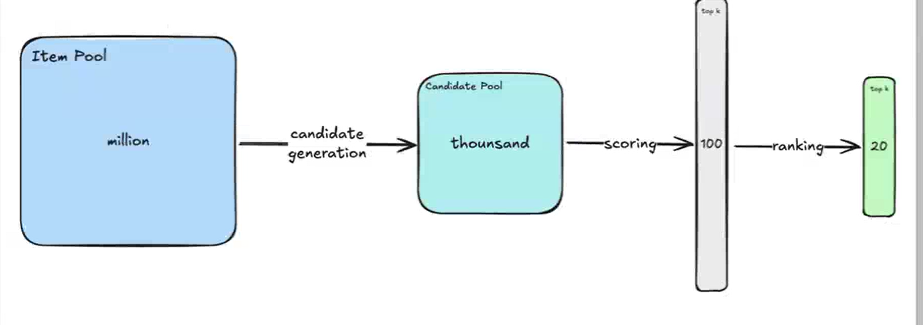

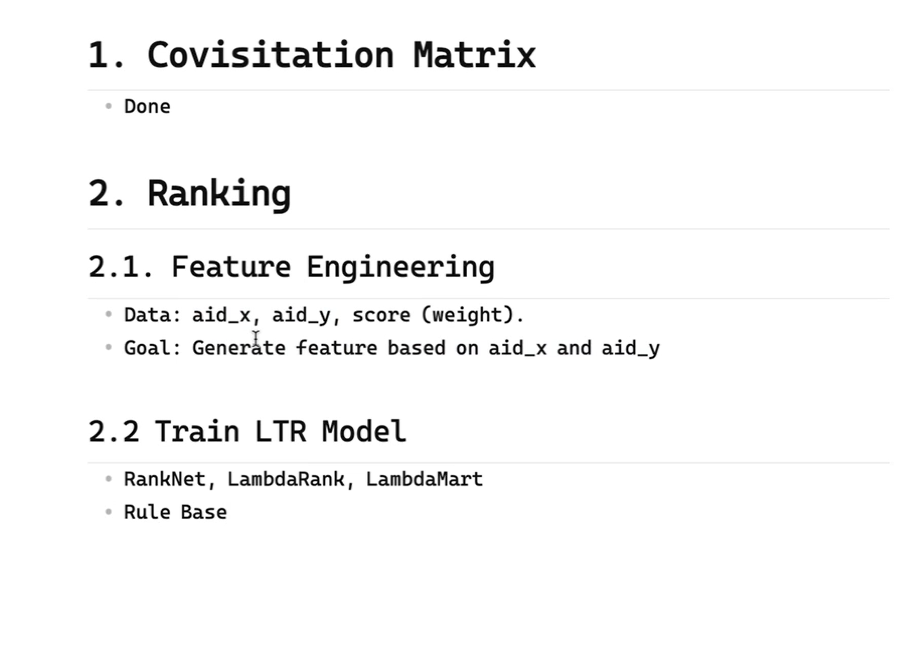

# **Báo Cáo Triển Khai Hệ Thống Gợi Ý Dựa Trên Phương Pháp Candidate Rerank và Covisit Matrices**

## **1. Giới Thiệu**

Trong cuộc thi **"OTTO – Multi-Objective Recommender System"** trên Kaggle, mục tiêu là xây dựng một hệ thống gợi ý sản phẩm dựa trên các phiên giao dịch thực tế của người dùng trong môi trường thương mại điện tử. Phương pháp được triển khai trong báo cáo này tập trung vào **Candidate Rerank với Covisit Matrices**, một trong những phương pháp hiệu quả giúp cải thiện chất lượng gợi ý sản phẩm. Phương pháp này kết hợp việc chọn lựa các sản phẩm ứng viên dựa trên hành vi trước đó của người dùng và tính toán mối quan hệ đồng ghé thăm giữa các sản phẩm để xếp hạng lại danh sách sản phẩm ứng viên.

## **2. Mục Tiêu**

- **Xây dựng hệ thống gợi ý sản phẩm** dựa trên hành vi người dùng trong các phiên giao dịch.
- **Áp dụng phương pháp Candidate Rerank với Covisit Matrices** để cải thiện độ chính xác của hệ thống gợi ý.
- **Đánh giá hiệu suất mô hình** sử dụng các chỉ số như NDCG và Recall@k.

## **3. Phương Pháp Triển Khai**

Phương pháp **Candidate Rerank với Covisit Matrices** bao gồm các bước chính:

1. **Chuẩn bị Dữ liệu**
2. **Xây dựng Covisit Matrices**
3. **Tạo Danh sách Ứng viên (Candidate Generation)**
4. **Kỹ thuật Feature Engineering**
5. **Huấn luyện Mô hình Reranker**
6. **Triển khai và Dự đoán**
7. **Đánh giá Mô hình**
8. **Tối ưu hóa và Lưu ý**

### **3.1. Chuẩn bị Môi trường và Thư viện**

Trước khi bắt đầu, cần đảm bảo rằng môi trường làm việc đã được cài đặt các thư viện cần thiết:

```bash
pip install pandas numpy lightgbm scikit-learn
```

### **3.2. Chuẩn bị Dữ liệu**

Giả sử dữ liệu được cung cấp dưới dạng DataFrame `df` với các cột:

- `session_id`: ID của phiên giao dịch.
- `timestamp`: Thời gian hành động.
- `aid`: ID sản phẩm.
- `action_type`: Loại hành động (click, add-to-cart, order).
- `target_aid`: Sản phẩm mục tiêu cần dự đoán trong mỗi session.

#### **3.2.1. Phân chia Dữ liệu thành Training và Validation**

Chia dữ liệu dựa trên thời gian để đảm bảo rằng dữ liệu validation xảy ra sau dữ liệu training.

```python
import pandas as pd

# Giả sử df đã được sắp xếp theo thời gian tăng dần
split_time = df['timestamp'].quantile(0.8)  # 80% dữ liệu cho training

train = df[df['timestamp'] < split_time]
valid = df[df['timestamp'] >= split_time]
```

### **3.3. Xây dựng Covisit Matrices**

Ma trận đồng ghé thăm thể hiện mối quan hệ giữa các sản phẩm dựa trên hành vi người dùng. Đây là một thành phần quan trọng giúp hệ thống hiểu được sự liên kết giữa các sản phẩm trong cùng một phiên giao dịch.

```python
# Đếm số lần hai sản phẩm cùng xuất hiện trong cùng một session
covisit = train.groupby(['aid_x', 'aid_y']).size().reset_index(name='count')

# Lọc các cặp sản phẩm có số lượt đồng ghé thăm cao
covisit = covisit.sort_values(by='count', ascending=False).head(10000)  # Giới hạn để quản lý bộ nhớ
```

### **3.4. Tạo Danh sách Ứng viên (Candidate Generation)**

Chọn các sản phẩm phổ biến nhất làm ứng viên cho mỗi session. Việc này giúp giảm không gian tìm kiếm và tập trung vào các sản phẩm có khả năng cao được người dùng quan tâm.

```python
from collections import Counter

# Đếm tần suất xuất hiện của từng sản phẩm
aids_counter = Counter(train['aid'])

# Lấy top 50 sản phẩm phổ biến
top_aids = [aid for aid, count in aids_counter.most_common(50)]
```

### **3.5. Kỹ thuật Feature Engineering**

#### **3.5.1. Tạo Đặc trưng Tương tác từ Covisit Matrices**

Trích xuất các đặc trưng từ ma trận đồng ghé thăm cho từng sản phẩm trong session. Các đặc trưng này thể hiện mức độ liên kết giữa các sản phẩm.

```python
def extract_covisit_features(aid, covisit_matrix, top_n=50):
    # Lấy các sản phẩm đồng ghé thăm với aid
    related = covisit_matrix[covisit_matrix['aid_x'] == aid].head(top_n)
    return related['count'].values.tolist()

# Áp dụng cho tất cả các sản phẩm trong danh sách ứng viên
for aid in top_aids:
    covisit_features = extract_covisit_features(aid, covisit)
    # Lưu các đặc trưng này vào DataFrame hoặc một cấu trúc dữ liệu phù hợp
```

#### **3.5.2. Đặc trưng Người dùng và Sản phẩm**

Tạo các đặc trưng cơ bản như tổng số lần click, add-to-cart, order cho từng sản phẩm.

```python
# Tạo các đặc trưng đếm cho mỗi aid
aid_features = train.groupby(['aid', 'action_type']).size().unstack(fill_value=0).reset_index()
aid_features.columns = ['aid', 'clicks', 'carts', 'orders']
```

### **3.6. Xây dựng Dataset cho Mô hình Reranker**

Gán nhãn cho sản phẩm đã được mua hoặc thêm vào giỏ hàng trong session.

```python
# Giả sử bạn có một cột 'target_aid' là sản phẩm mục tiêu trong mỗi session
df_rerank = valid.copy()
df_rerank['label'] = (df_rerank['aid'] == df_rerank['target_aid']).astype(int)
```

### **3.7. Huấn luyện Mô hình LightGBM**

Sử dụng LightGBM để huấn luyện mô hình xếp hạng dựa trên các đặc trưng đã xây dựng.

```python
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Chuẩn bị dữ liệu
X = df_rerank.drop(['label', 'target_aid'], axis=1)
y = df_rerank['label']

# Chia nhỏ dữ liệu để training và validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình LightGBM
lgb_model = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg',
    learning_rate=0.1,
    n_estimators=100
)

# Huấn luyện mô hình
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_group=[len(y_val)],
    early_stopping_rounds=10
)
```

### **3.8. Triển khai và Dự đoán**

#### **3.8.1. Tạo Danh sách Ứng viên cho Mỗi Session**

Kết hợp các sản phẩm từ Covisit Matrices và các sản phẩm phổ biến để tạo danh sách ứng viên cho mỗi session.

```python
def generate_candidates(session_id, covisit_matrix, top_aids):
    # Lấy các sản phẩm trong session
    session_aids = train[train['session_id'] == session_id]['aid'].unique()
    
    # Tìm các sản phẩm liên quan từ covisit
    candidates = []
    for aid in session_aids:
        related = covisit_matrix[covisit_matrix['aid_x'] == aid]['aid_y'].tolist()
        candidates.extend(related)
    
    # Thêm các sản phẩm phổ biến
    candidates.extend(top_aids)
    
    # Loại bỏ trùng lặp và giới hạn số lượng
    candidates = list(set(candidates))[:50]
    return candidates
```

#### **3.8.2. Dự đoán Xếp hạng**

Sử dụng mô hình đã huấn luyện để xếp hạng lại các ứng viên.

```python
def rank_candidates(model, X_candidates):
    # Dự đoán điểm cho các ứng viên
    predictions = model.predict(X_candidates)
    
    # Sắp xếp các ứng viên theo điểm giảm dần
    ranked_candidates = [x for _, x in sorted(zip(predictions, candidates), reverse=True)]
    return ranked_candidates

# Áp dụng cho mỗi session trong validation
valid_sessions = valid['session_id'].unique()
for session in valid_sessions:
    candidates = generate_candidates(session, covisit, top_aids)
    X_candidates = prepare_features(candidates)  # Hàm này bạn cần định nghĩa để tạo đặc trưng
    ranked = rank_candidates(lgb_model, X_candidates)
    # Lưu hoặc sử dụng ranked_candidates cho việc đánh giá
```

### **3.9. Đánh giá Mô hình**

Sử dụng các chỉ số như NDCG và Recall@k để đánh giá hiệu suất của mô hình trên tập validation.

```python
from sklearn.metrics import ndcg_score

# Tính NDCG cho tập validation
y_true = y_val.values.reshape(1, -1)
y_pred = lgb_model.predict(X_val).reshape(1, -1)
score = ndcg_score(y_true, y_pred)
print(f'NDCG Score: {score}')
```

### **3.10. Tối ưu hóa và Lưu ý**

- **Hiệu suất**: Đối với các tập dữ liệu lớn, nên sử dụng các thư viện tối ưu hóa như RAPIDS cuDF để tăng tốc độ xử lý.
- **Tối ưu hóa Hyperparameters**: Sử dụng các kỹ thuật như Bayesian Optimization để tìm kiếm các hyperparameters tốt nhất cho LightGBM.
- **Xử lý Cold-start**: Thêm các đặc trưng bổ sung cho các sản phẩm mới bằng cách sử dụng thông tin phổ biến hoặc metadata.
- **Quản lý Bộ nhớ**: Giới hạn kích thước của Covisit Matrices để tránh sử dụng quá nhiều bộ nhớ.

## **4. Kết Luận**

Phương pháp **Candidate Rerank với Covisit Matrices** là một cách tiếp cận hiệu quả để xây dựng hệ thống gợi ý sản phẩm trong môi trường thương mại điện tử. Bằng cách kết hợp việc chọn lựa các sản phẩm ứng viên dựa trên hành vi người dùng và tính toán mối quan hệ đồng ghé thăm giữa các sản phẩm, hệ thống có thể cung cấp các gợi ý chính xác và phù hợp hơn. 

Để đạt được hiệu suất tối ưu, cần chú trọng vào việc xây dựng các đặc trưng phong phú và tối ưu hóa quy trình xử lý dữ liệu. Ngoài ra, việc sử dụng các kỹ thuật tối ưu hóa và xử lý bộ nhớ hiệu quả sẽ giúp hệ thống hoạt động nhanh chóng và chính xác hơn.

Nếu bạn gặp bất kỳ khó khăn nào trong quá trình triển khai hoặc cần thêm thông tin chi tiết về từng bước, đừng ngần ngại liên hệ để được hỗ trợ thêm.

## **5. Tài Liệu Tham Khảo**

- [Kaggle Competition: OTTO – Multi-Objective Recommender System](https://www.kaggle.com/competitions/otto-recommender-system)
- [LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html)

---

**Lưu ý:** Báo cáo này chỉ mang tính chất tham khảo và có thể cần điều chỉnh tùy thuộc vào cấu trúc dữ liệu cụ thể và yêu cầu của dự án.

# **Khung Các Phương Pháp Sử Dụng Trong Cuộc Thi "OTTO – Multi-Objective Recommender System"**

## **1. Giới Thiệu Chung**

Cuộc thi **"OTTO – Multi-Objective Recommender System"** trên Kaggle yêu cầu xây dựng một hệ thống gợi ý sản phẩm dựa trên các phiên giao dịch thực tế của người dùng trong môi trường thương mại điện tử. Ba phương pháp chính đã được sử dụng để giải quyết vấn đề này bao gồm:

- **Cách 1:** Sử dụng phương pháp **Candidate Rerank** kết hợp với **Covisit Matrices**.
- **Cách 2:** Phương pháp của **NikhilMishra**, tập trung vào **Single Model Approach** và **Feature Engineering**.
- **Cách 3:** Phương pháp của **THLUO**, kết hợp nhiều nguồn thu hồi và xây dựng bộ đặc trưng phong phú.

## **2. Tổng Quan Các Phương Pháp**

### **2.1. Cách 1: Candidate Rerank và Covisit Matrices**

#### **2.1.1. Mục Tiêu**
- Chọn lựa các sản phẩm ứng viên dựa trên hành vi người dùng.
- Tính toán mối quan hệ đồng ghé thăm giữa các sản phẩm.
- Xếp hạng lại các sản phẩm ứng viên dựa trên các đặc trưng đã xây dựng.

#### **2.1.2. Các Bước Triển Khai**
1. **Chuẩn bị Dữ liệu:**
   - Phân chia dữ liệu thành tập training và validation dựa trên thời gian.
2. **Xây dựng Covisit Matrices:**
   - Tạo ma trận đồng ghé thăm cho các loại hành vi như click, add-to-cart, order.
3. **Candidate Generation:**
   - Chọn các sản phẩm phổ biến nhất làm ứng viên cho mỗi session.
4. **Feature Engineering:**
   - Tạo các đặc trưng tương tác từ Covisit Matrices.
   - Tạo các đặc trưng cơ bản về người dùng và sản phẩm.
5. **Huấn luyện Mô hình Reranker:**
   - Sử dụng mô hình Gradient Boosted Trees (LightGBM) để xếp hạng lại các ứng viên.
6. **Triển khai và Dự đoán:**
   - Tạo danh sách ứng viên cho mỗi session.
   - Dự đoán xếp hạng và sắp xếp các ứng viên dựa trên mô hình đã huấn luyện.
7. **Đánh giá Mô hình:**
   - Sử dụng các chỉ số như NDCG và Recall@k để đánh giá hiệu suất.
8. **Tối ưu hóa và Lưu ý:**
   - Sử dụng thư viện GPU để tăng tốc xử lý.
   - Chuẩn hóa các đặc trưng và tối ưu hóa hyperparameters.

### **2.2. Cách 2: Phương pháp của NikhilMishra**

#### **2.2.1. Mục Tiêu**
- Tối ưu hóa quy trình chọn lựa ứng viên và xây dựng đặc trưng để cải thiện hiệu suất hệ thống gợi ý.
- Sử dụng một mô hình duy nhất để xử lý tất cả các loại hành vi (click, cart, order).

#### **2.2.2. Các Bước Triển Khai**
1. **Candidates Generation:**
   - Sử dụng Covisit Matrices tương tự như Cách 1.
   - Phân loại các hành động (click, cart, order) và tính toán trọng số dựa trên tần suất và khoảng cách giữa các sản phẩm.
2. **Feature Engineering:**
   - Tạo các đặc trưng cơ bản như tần suất, tỷ lệ chuyển đổi, recency.
   - Tạo các đặc trưng liên quan đến mối quan hệ giữa các sản phẩm trong session.
3. **Huấn luyện Mô hình Reranker:**
   - Sử dụng LightGBM với sampling tiêu cực và nhiều đặc trưng để huấn luyện mô hình xếp hạng.
4. **Inference:**
   - Sử dụng Treelite để giảm thời gian dự đoán.
5. **Đặc điểm Nổi Bật:**
   - **Single Model Approach:** Huấn luyện một mô hình duy nhất cho tất cả các loại hành vi, giúp cải thiện hiệu suất và đơn giản hóa quy trình.
   - **Feature Utilization:** Sử dụng ranking của mô hình bước 1 làm đặc trưng cho mô hình bước 2.

### **2.3. Cách 3: Phương pháp của THLUO**

#### **2.3.1. Mục Tiêu**
- Kết hợp nhiều nguồn thu hồi và xây dựng một bộ đặc trưng phong phú để nâng cao hiệu suất hệ thống gợi ý.
- Sử dụng mô hình binary classifier để dự đoán xác suất gợi ý sản phẩm.

#### **2.3.2. Các Bước Triển Khai**
1. **Retrieval:**
   - Kết hợp ba phương pháp thu hồi:
     - **Covisitation Matrix** từ CHRIS DEOTTE.
     - **i2i similarity** giữa các sản phẩm click-to-click và click-to-cart.
2. **Feature Engineering:**
   - Xây dựng các đặc trưng phong phú bao gồm:
     - Đặc trưng session, người dùng, sản phẩm.
     - Các đặc trưng liên quan đến similarity và embeddings.
3. **Huấn luyện Mô hình:**
   - Sử dụng LightGBM binary classifier với các tham số cụ thể (learning rate, số vòng lặp).
4. **Ensemble:**
   - Sử dụng blend probability từ các mô hình đã được submit trước đó để tăng điểm số.
5. **Đặc điểm Nổi Bật:**
   - **Comprehensive Feature Set:** Xây dựng một bộ đặc trưng phong phú và đa dạng, kết hợp giữa các đặc trưng cơ bản và các đặc trưng phức tạp từ similarity matrices.
   - **Efficient Inference:** Sử dụng Radek’s CV strategy và Treelite để tối ưu hóa thời gian dự đoán.

## **3. So Sánh Các Phương Pháp**

| **Tiêu Chí**                  | **Cách 1: Candidate Rerank & Covisit Matrices** | **Cách 2: NikhilMishra**                 | **Cách 3: THLUO**                        |
|-------------------------------|------------------------------------------------|-----------------------------------------|------------------------------------------|
| **Phương Pháp Chính**         | Candidate Rerank, Covisit Matrices             | Single Model Approach, Covisit Matrices | Multiple Retrieval Sources, Binary Classifier |
| **Mô hình Sử Dụng**           | LightGBM Reranker                              | LightGBM Reranker                       | LightGBM Binary Classifier               |
| **Kỹ Thuật Feature Engineering** | Đặc trưng từ Covisit Matrices, người dùng và sản phẩm | Đặc trưng từ Covisit Matrices, ranking feature | Đặc trưng phong phú từ nhiều nguồn       |
| **Chiến Lược Inference**      | Xếp hạng lại ứng viên                          | Sử dụng Treelite để tăng tốc            | Blend probability từ nhiều mô hình       |
| **Ưu Điểm**                   | Đơn giản, hiệu quả với tài nguyên hạn chế      | Tối ưu hóa quy trình, cải thiện hiệu suất | Bộ đặc trưng phong phú, hiệu suất tối đa |
| **Nhược Điểm**                | Có thể hạn chế về độ phức tạp và tính linh hoạt | Cần tối ưu hóa mô hình và đặc trưng tốt | Yêu cầu tài nguyên tính toán và bộ nhớ lớn |

## **4. Khuyến Nghị**

- **Nếu bạn có tài nguyên tính toán hạn chế:**
  - Bắt đầu với **Cách 1 hoặc Cách 2**, vì chúng có cấu trúc đơn giản hơn và hiệu quả cao.
  
- **Nếu bạn muốn đạt hiệu suất tối đa và có đủ tài nguyên:**
  - Áp dụng **Cách 3** để tận dụng nhiều nguồn dữ liệu và xây dựng bộ đặc trưng phong phú.

- **Tối ưu hóa và thử nghiệm:**
  - Dù chọn phương pháp nào, hãy đảm bảo tối ưu hóa các hyperparameter và thử nghiệm với các bộ đặc trưng khác nhau để tìm ra cấu hình tốt nhất cho dữ liệu của bạn.

## **5. Công Cụ và Thư Viện Cần Thiết**

- **Thư viện Machine Learning:**
  - **LightGBM** hoặc **XGBoost** cho mô hình reranker.
  
- **Thư viện Xử Lý Dữ Liệu:**
  - **Pandas** hoặc **CuDF** cho xử lý dữ liệu.
  
- **Thư viện Tối Ưu Hóa:**
  - **Bayesian Optimization** (ví dụ: **BayesSearchCV** từ **scikit-optimize**).
  
- **Thư viện GPU (nếu cần):**
  - **RAPIDS cuDF** để tăng tốc xử lý các ma trận đồng ghé thăm.

- **Thư viện Inference Tối Ưu:**
  - **Treelite** để giảm thời gian dự đoán.

## **6. Kết Luận**

Việc lựa chọn phương pháp phù hợp phụ thuộc vào nguồn lực và mục tiêu cụ thể của dự án. **Cách 1** và **Cách 2** là những lựa chọn tốt cho các tình huống có hạn chế về tài nguyên, trong khi **Cách 3** phù hợp với những ai muốn đạt được hiệu suất tối đa và sẵn sàng đầu tư vào xây dựng một hệ thống phức tạp hơn. Bất kể phương pháp nào được chọn, việc tối ưu hóa các đặc trưng và hyperparameters sẽ đóng vai trò quan trọng trong việc cải thiện hiệu suất của hệ thống gợi ý.

---

**Tài Liệu Tham Khảo:**

- [Kaggle Competition: OTTO – Multi-Objective Recommender System](https://www.kaggle.com/competitions/otto-recommender-system)
- [LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html)

## 

1. Covisitation Matrix 

2. Ranking 
2.1 Feature Engineering 
- Data: 
- Goal: Generate feature based on aid_x and aid_y
- Example: freq aid_x
2.2 Train LTR Model 
- RankNet, LambdaRank, LambdaMart
- Rule Base

(Candidate -Rerank, có thể nhắc đến RNN trong report nhưng sẽ ko dùng nó 
RNN ( Not used, because of ...., mention in report). 

Train model thì sẽ train trên Candidate thôi, chứ không train trên data gốc đâu 

train mấy cái XGboost, model Rerank, Embedding, ... tương tự ... 

Data của candidate chỉ đơn giản thôi . 


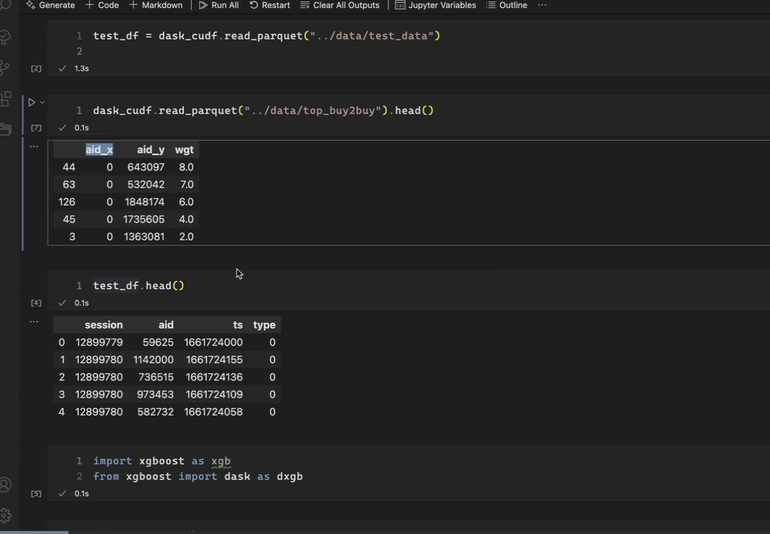

## Rule base: 
## 